# Final Project - MET CS 677  
## COVID-19 Radiography Analysis: Image Segmentation and Classification  
**By: Maryam Baizhigitova**  

This project focuses on utilizing advanced deep learning techniques for chest X-ray image segmentation and classification using the [COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database). The workflow integrates the fine-tuned Segment Anything Model-2 (SAM-2) for segmentation and machine learning classifiers for accurate diagnosis across four categories:  
1. **COVID-19**  
2. **Lung Opacity**  
3. **Viral Pneumonia**  
4. **Normal**  


## Environment Setup

The environment setup begins with extracting the project files. The command `!unzip Maryam_Baizhigitova_final.zip` is used to unpack the compressed project folder, providing access to all required datasets, scripts, and configurations for the subsequent steps in the workflow.


In [1]:
!unzip Maryam_Baizhigitova_final.zip

Archive:  Maryam_Baizhigitova_final.zip
   creating: Maryam_Baizhigitova_final/
  inflating: Maryam_Baizhigitova_final/fine_tuned_sam2.torch  
  inflating: __MACOSX/Maryam_Baizhigitova_final/._fine_tuned_sam2.torch  
  inflating: Maryam_Baizhigitova_final/.DS_Store  
  inflating: __MACOSX/Maryam_Baizhigitova_final/._.DS_Store  
  inflating: Maryam_Baizhigitova_final/Maryam_Baizhigitova_final_project.ipynb  
  inflating: __MACOSX/Maryam_Baizhigitova_final/._Maryam_Baizhigitova_final_project.ipynb  
  inflating: Maryam_Baizhigitova_final/sam2_hiera_tiny.pt  
  inflating: __MACOSX/Maryam_Baizhigitova_final/._sam2_hiera_tiny.pt  
   creating: Maryam_Baizhigitova_final/.ipynb_checkpoints/
  inflating: Maryam_Baizhigitova_final/sam2_hiera_small.pt  
  inflating: __MACOSX/Maryam_Baizhigitova_final/._sam2_hiera_small.pt  
   creating: Maryam_Baizhigitova_final/COVID_data/
  inflating: __MACOSX/Maryam_Baizhigitova_final/._COVID_data  
   creating: Maryam_Baizhigitova_final/sam2/
  inflating: __

In [2]:
# Step 1: Environment Setup

# Install SAM-2 from folder (sam2), install dependencies, and download pre-trained models.
import os
import subprocess

# Define the HOME directory as the current working directory
HOME = os.getcwd()
print(f"HOME: {HOME}")

# Navigate to the specified directory
project_dir = os.path.join(HOME, "Maryam_Baizhigitova_final")

# Change to the 'sam2' subdirectory within HOME
sam2_path = os.path.join(project_dir, "sam2")
os.chdir(sam2_path)
print(f"Current Directory: {os.getcwd()}")

# Install the SAM2 package in editable mode quietly
subprocess.run(["pip", "install", "-e", ".", "-q"], check=True)

print("SAM2 package installed successfully!")

HOME: /content
Current Directory: /content/Maryam_Baizhigitova_final/sam2
SAM2 package installed successfully!


In [3]:
# Step 2: Load all necessary libraries

# Standard libraries
import os
import random
import gc

# Third-party libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler

# Project-specific imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

/content/Maryam_Baizhigitova_final/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()



## Data Exploration
This section explores the dataset and checks for missing values.

### Step 1: Organize the dataset, define directories for images and masks

In [4]:
# Change the working directory to the specified path
os.chdir(project_dir)
HOME = os.getcwd()

# Define the base directories for images and masks relative to the current working directory
base_dirs = {
    "COVID": os.path.join(HOME, "COVID_data/COVID/images"),
    "Lung_Opacity": os.path.join(HOME, "COVID_data/Lung_Opacity/images"),
    "Viral_Pneumonia": os.path.join(HOME, "COVID_data/Viral_Pneumonia/images"),
    "Normal": os.path.join(HOME, "COVID_data/Normal/images")
}

mask_dirs = {
    "COVID": os.path.join(HOME, "COVID_data/COVID/masks"),
    "Lung_Opacity": os.path.join(HOME, "COVID_data/Lung_Opacity/masks"),
    "Viral_Pneumonia": os.path.join(HOME, "COVID_data/Viral_Pneumonia/masks"),
    "Normal": os.path.join(HOME, "COVID_data/Normal/masks")
}


### Step 2: Data Exploration



In [5]:
# Analyzing data distribution and checking for missing values

data_summary = {}
for category, base_dir in base_dirs.items():
    num_images = len(os.listdir(base_dir))
    data_summary[category] = num_images

class_counts = pd.DataFrame(list(data_summary.items()), columns=['Category', 'Number of Images'])
print("Initial Class Distribution:")
print(class_counts)

# Checking for missing values
missing_values = {}
for category, base_dir in base_dirs.items():
    num_images = len(os.listdir(base_dir))
    data_summary[category] = num_images

    # Check for missing masks
    mask_count = len(os.listdir(mask_dirs[category]))
    missing_values[category] = num_images - mask_count

class_counts = pd.DataFrame(list(data_summary.items()), columns=['Category', 'Number of Images'])
missing_counts = pd.DataFrame(list(missing_values.items()), columns=['Category', 'Missing Masks'])
print("Missing Masks Count:")
print(missing_counts)

Initial Class Distribution:
          Category  Number of Images
0            COVID               250
1     Lung_Opacity               250
2  Viral_Pneumonia               250
3           Normal               250
Missing Masks Count:
          Category  Missing Masks
0            COVID              0
1     Lung_Opacity              0
2  Viral_Pneumonia              0
3           Normal              0


### Step 3: Visualization of Class Distribution:

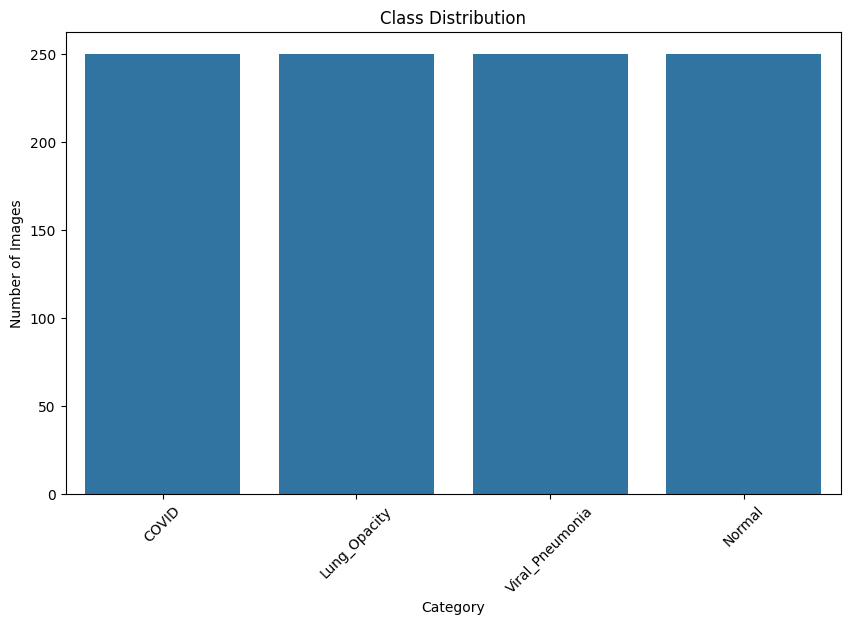

In [6]:
# A bar chart visualizing the number of images per category is included for better understanding.
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Number of Images', data=class_counts)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

## SAM-2 Model Training  
This section initializes the Segment Anything Model-2 (SAM-2), a cutting-edge image segmentation model, and fine-tunes it using the prepared dataset to achieve optimal performance. Link to the SAM-2 repository: [https://github.com/facebookresearch/sam2.git](https://github.com/facebookresearch/sam2.git)

### Step 1: Data Splitting and Organization

- The data is split into **80% training and 20% testing sets** to prepare for model training and evaluation. The size of each subset is displayed for verification.

In [7]:
# Step 5: Data Splitting

# Split the dataset into training and testing sets
data_dir = HOME  # Base directory for the dataset
data = []  # List of files in the dataset

# Define valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

# Define the classes and their corresponding directories
classes = ["COVID", "Lung_Opacity", "Viral_Pneumonia", "Normal"]

# Go over all classes
for class_name in classes:
    image_dir = os.path.join(data_dir, f"COVID_data/{class_name}/images/")
    mask_dir = os.path.join(data_dir, f"COVID_data/{class_name}/masks/")

    # Go over all image files in the class folder
    for name in os.listdir(image_dir):
        # Check if the file has a valid image extension
        if name.lower().endswith(valid_extensions):
            # Construct file paths for images and corresponding masks
            data.append({
                "image": os.path.join(image_dir, name),
                f"{class_name.lower()}_annotation": os.path.join(mask_dir, name[:-4] + ".png"),
            })

# Split the data into 80% train and 20% test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Display the length of train and test sets
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 800
Number of test samples: 200


### Step 2: Data Augmentation and Preprocessing
- This function reads an image and its corresponding mask from specified file paths, converts the image from BGR to RGB format, and resizes both the image and mask to a uniform target size (1024x1024). The resizing ensures compatibility with the model's input dimensions, using nearest-neighbor interpolation for masks to preserve discrete class values.

In [8]:
# Define functions for reading and resizing images and masks
def read_image(image_path, mask_path):
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)

    # Resize both image and mask to the same size
    target_size = (1024, 1024)
    img = cv2.resize(img, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Use nearest for masks

    return img, mask

### Step 3: Batch Data Preparation and Visualization
- This step involves selecting a random data sample, processing its associated image and annotation mask, and generating a binary mask along with random sampling of key points within the mask. It also provides an option to visualize the image, binary mask, and selected points for better understanding and debugging.

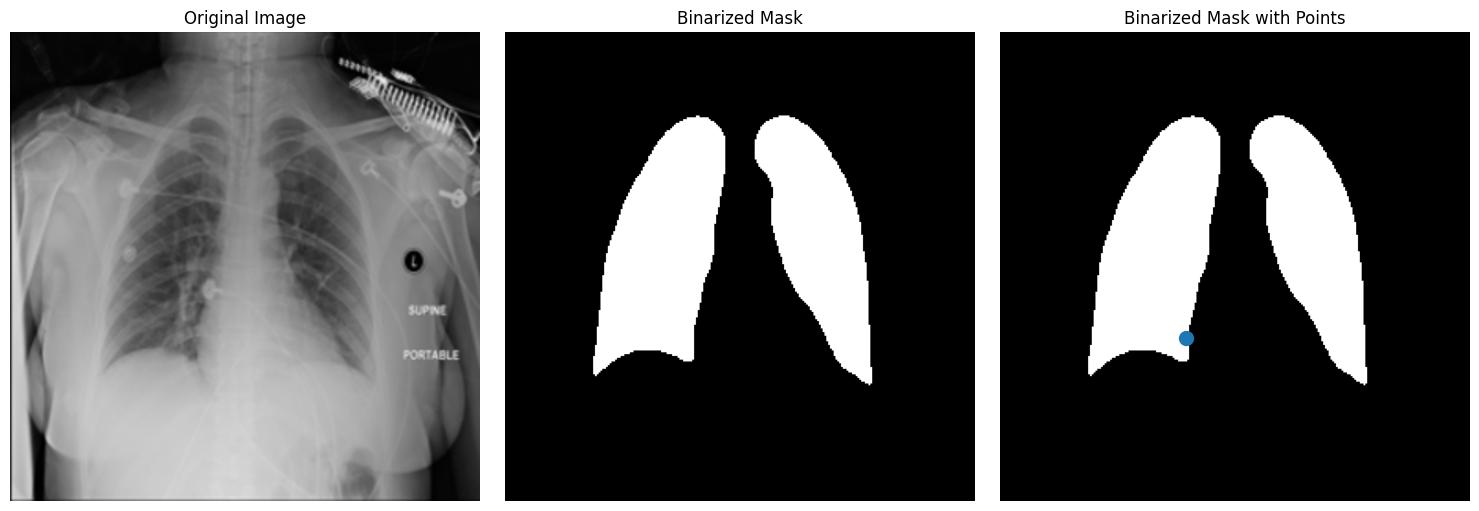

In [9]:
# Function to read a batch of data
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Check if the entry is valid
    if ent is None or "image" not in ent:
        print(f"Invalid entry in data: {ent}")
        return None, None, None, 0

    # Get full paths
    Img, ann_map = read_image(ent["image"], ent[f"{ent['image'].split('/')[-3].lower()}_annotation"])

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Example usage
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

### Step 4: Model Initialization and Training Setup


In [10]:
def initialize_model():
    """
    Initialize the SAM-2 model by loading the checkpoint and configuration,
    clearing GPU memory, and setting up the predictor for image segmentation tasks.
    """
    torch.cuda.empty_cache()  # Clear GPU cache
    gc.collect()  # Collect garbage to free memory
    sam2_checkpoint = "sam2_hiera_tiny.pt"  # Path to the SAM-2 model checkpoint
    model_cfg = "sam2_hiera_t.yaml"  # Path to the SAM-2 model configuration
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")  # Build SAM-2 model on GPU
    predictor = SAM2ImagePredictor(sam2_model)  # Initialize the predictor for segmentation
    return predictor

# Initialize the model
print("Starting model initialization...")
predictor = initialize_model()
print("Model initialized successfully!")

# Training Setup
NO_OF_STEPS = 5000  # Total number of training steps
accumulation_steps = 16  # Number of gradient accumulation steps
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"  # Name for the fine-tuned model checkpoint

# Initialize optimizer and scheduler
optimizer = torch.optim.AdamW(
    predictor.model.parameters(),  # Model parameters to optimize
    lr=0.0005,  # Learning rate
    weight_decay=1e-4  # Weight decay for regularization
)
scheduler = lr_scheduler.StepLR(
    optimizer,  # Optimizer
    step_size=500,  # Number of steps before reducing the learning rate
    gamma=0.2  # Factor by which the learning rate is reduced
)


Starting model initialization...
Model initialized successfully!


In [11]:
def initialize_model():
    torch.cuda.empty_cache()
    gc.collect()
    sam2_checkpoint = "sam2_hiera_tiny.pt"
    model_cfg = "sam2_hiera_t.yaml"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
    predictor = SAM2ImagePredictor(sam2_model)
    return predictor

# Initialize model
print("Starting model initialization...")
predictor = initialize_model()
print("Model initialized successfully!")

# Training setup
NO_OF_STEPS = 5000
accumulation_steps = 16
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

# Initialize optimizer and scheduler
optimizer = torch.optim.AdamW(predictor.model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)

Starting model initialization...
Model initialized successfully!


### Step 5: Training the Model
- Fine-tune the SAM-2 model using training data (include a loop for training, saving checkpoints, and calculating IoU).

## Note:
Model already trained, and saved in the Maryam_Baizhigitova_final folder as fine_tuned_sam2.torch, so it can be directly used, by skipping this step 5, and going to the next step 6.



Starting training...
Step 100: Accuracy (IoU) = 0.8599  GPU memory: 337.8MB
Step 200: Accuracy (IoU) = 0.9437  GPU memory: 325.8MB
Step 300: Accuracy (IoU) = 0.9035  GPU memory: 337.8MB
Step 400: Accuracy (IoU) = 0.7592  GPU memory: 337.8MB
Step 500: Accuracy (IoU) = 0.8957  GPU memory: 325.8MB
Step 600: Accuracy (IoU) = 0.8090  GPU memory: 337.8MB
Step 700: Accuracy (IoU) = 0.8282  GPU memory: 325.8MB
Step 800: Accuracy (IoU) = 0.9558  GPU memory: 325.8MB
Step 900: Accuracy (IoU) = 0.9691  GPU memory: 325.8MB
Step 1000: Accuracy (IoU) = 0.9524  GPU memory: 337.8MB
Step 1100: Accuracy (IoU) = 0.8261  GPU memory: 337.8MB
Step 1200: Accuracy (IoU) = 0.9381  GPU memory: 337.8MB
Step 1300: Accuracy (IoU) = 0.9434  GPU memory: 325.8MB
Step 1400: Accuracy (IoU) = 0.8809  GPU memory: 337.8MB
Step 1500: Accuracy (IoU) = 0.9543  GPU memory: 325.8MB
Step 1600: Accuracy (IoU) = 0.9533  GPU memory: 325.8MB
Step 1700: Accuracy (IoU) = 0.9403  GPU memory: 325.8MB
Step 1800: Accuracy (IoU) = 0.9637  

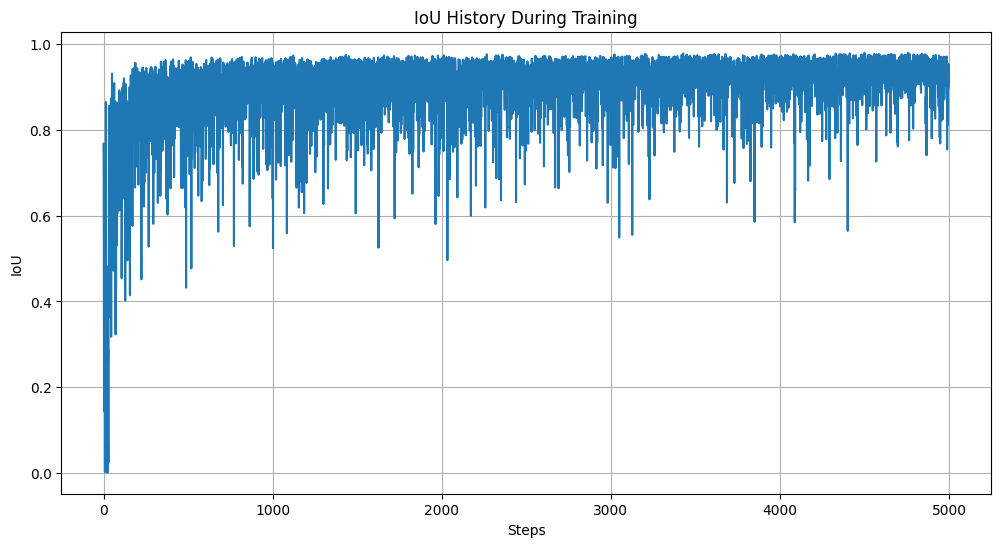


Training completed!
Final Accuracy (IoU): 0.9220


In [12]:
# Training loop with IoU tracking
print("Starting training...")
best_iou = 0
running_iou = 0
iou_history = []  # To store IoU values for plotting

for step in range(1, NO_OF_STEPS + 1):
    try:
        torch.cuda.empty_cache()
        gc.collect()

        # Read a batch of data
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
        if image is None or mask is None or num_masks == 0:
            continue

        # Prepare input points and labels
        input_point = torch.from_numpy(input_point).cuda() if isinstance(input_point, np.ndarray) else input_point
        input_point = input_point[:1]
        input_label = torch.ones((1, 1), device='cuda')

        # Set image for the predictor
        predictor.set_image(image)
        del image
        torch.cuda.empty_cache()

        # Prepare prompts
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )

        # Get embeddings
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None,
        )

        # Get high-resolution features
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

        # Decode masks
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=False,
            high_res_features=high_res_features,
        )

        # Process masks
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
        gt_mask = mask.cuda() if isinstance(mask, torch.Tensor) else torch.tensor(mask, device='cuda').float()

        # Ensure shapes match
        if prd_masks.shape[0] != gt_mask.shape[0]:
            gt_mask = gt_mask.expand(prd_masks.shape[0], *gt_mask.shape[1:])

        prd_mask = torch.sigmoid(prd_masks[:, 0])

        # Calculate IoU and losses
        seg_loss = F.binary_cross_entropy_with_logits(prd_masks[:, 0], gt_mask)
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        union = gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter
        dice_loss = 1 - (2 * inter + 1) / (union + 1)

        iou = inter / (union + 1e-6)
        current_iou = iou.mean().item()
        running_iou = 0.9 * running_iou + 0.1 * current_iou
        iou_history.append(current_iou)

        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + dice_loss.mean() + score_loss * 0.1
        loss = loss / accumulation_steps

        loss.backward()

        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}: Accuracy (IoU) = {current_iou:.4f}  GPU memory: {torch.cuda.memory_allocated(0) / 1024**2:.1f}MB")

        del low_res_masks, prd_masks, gt_mask, prd_mask
        torch.cuda.empty_cache()

        if step % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=0.1)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            torch.cuda.empty_cache()

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Step {step}: OUT OF MEMORY")
            torch.cuda.empty_cache()
            gc.collect()
            continue
        else:
            print(f"Step {step}: Error - {str(e)}")
            raise e
    except ValueError as e:
        print(f"Step {step}: Value Error - {str(e)}")
        continue

# Save the final model after training
torch.save({
    'model_state_dict': predictor.model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'best_iou': best_iou,
    'running_iou': running_iou
}, f"{FINE_TUNED_MODEL_NAME}.torch")
print(f"Final model saved as {FINE_TUNED_MODEL_NAME}.torch")

# Plot IoU history
plt.figure(figsize=(12, 6))
plt.plot(iou_history)
plt.title('IoU History During Training')
plt.xlabel('Steps')
plt.ylabel('IoU')
plt.grid(True)
plt.show()

print("\nTraining completed!")
print(f"Final Accuracy (IoU): {running_iou:.4f}")

### Step 6: Model Evaluation
- Evaluate the model on test data and calculate IoU for predictions

Visualizing results...


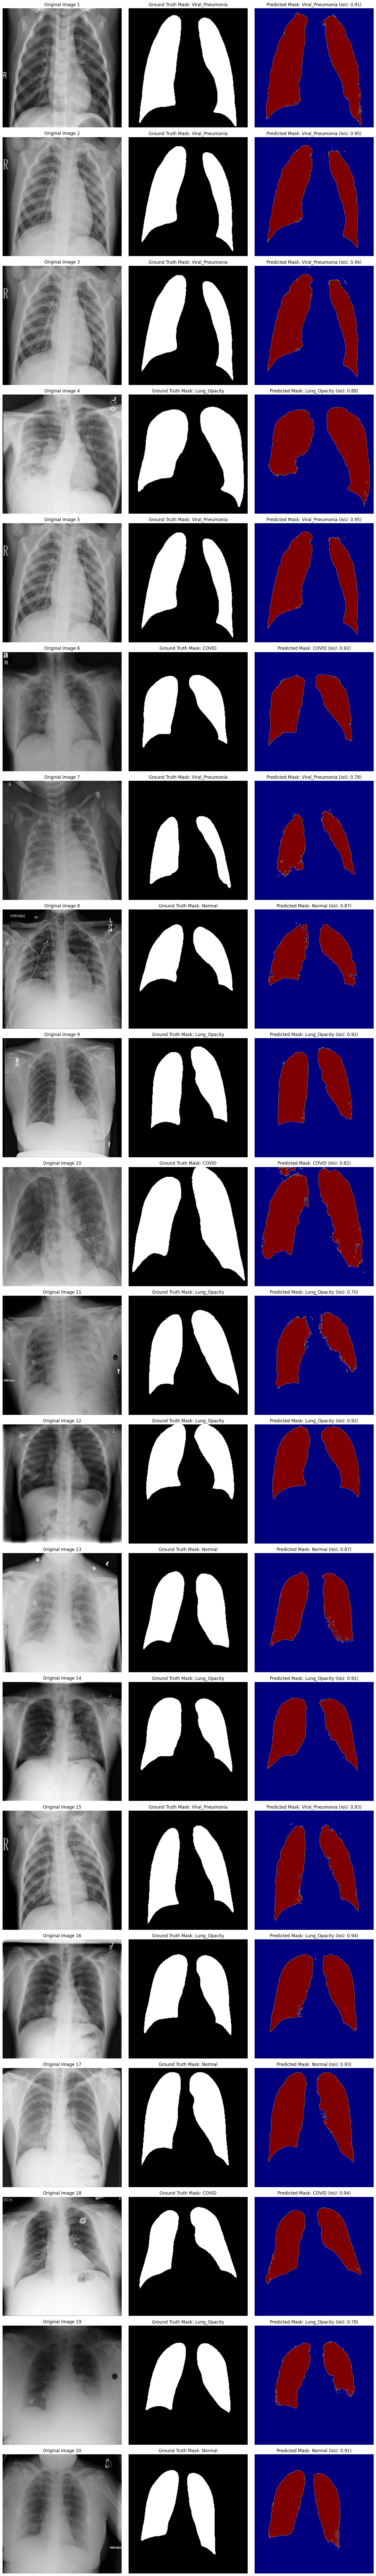

In [13]:
def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_cfg = "sam2_hiera_t.yaml"
    sam2_checkpoint = "sam2_hiera_tiny.pt"
    model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

# Function to read and resize image and mask
def read_image(image_path, mask_path):
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)

    # Resize both image and mask to the same size
    target_size = (1024, 1024)
    img = cv2.resize(img, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Use nearest for masks

    return img, mask

# Function to calculate IoU
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / (union + 1e-6)  # Add a small value to avoid division by zero

# Function to visualize results
def visualize_results(images, gt_masks, pred_masks, gt_class_names, pred_class_names, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f'Original Image {i + 1}')
        plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f'Ground Truth Mask: {gt_class_names[i]}')
        plt.imshow(gt_masks[i].squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        plt.axis('off')

        # Calculate IoU for the predicted mask
        iou = calculate_iou(pred_masks[i], gt_masks[i])

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f'Predicted Mask: {pred_class_names[i]} (IoU: {iou:.2f})')
        plt.imshow(pred_masks[i].squeeze(), cmap='jet')  # Squeeze to remove channel dimension
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to perform inference and collect results for visualization
def collect_results(predictor, test_data, num_samples=5):
    images = []
    gt_masks = []
    pred_masks = []
    gt_class_names = []
    pred_class_names = []
    iou_per_class = {}  # Dictionary to store IoU for each class

    for _ in range(num_samples):
        # Randomly select a test image from the test_data
        selected_entry = random.choice(test_data)
        image_path = selected_entry['image']
        mask_path = selected_entry[f"{selected_entry['image'].split('/')[-3].lower()}_annotation"]

        # Load the selected image and mask
        image, mask = read_image(image_path, mask_path)

        # Prepare input points
        _, binary_mask, points, num_masks = read_batch(test_data, visualize_data=False)

        # Ensure points are in the correct shape
        if points.shape[0] == 0:
            print(f"No points found for image {image_path}. Skipping this image.")
            continue

        input_points = points[:1]  # Use the first point for prediction

        # Perform inference
        with torch.no_grad():
            predictor.set_image(image)
            masks, _, _ = predictor.predict(
                point_coords=input_points,
                point_labels=np.ones([input_points.shape[0], 1])
            )

        # Process the predicted masks
        predicted_mask = masks[0].astype(bool)
        gt_mask = mask.astype(bool)

        # Resize the ground truth mask to match the predicted mask shape
        if predicted_mask.shape != gt_mask.shape:
            gt_mask = cv2.resize(gt_mask.astype(np.uint8), (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Collect results for visualization
        images.append(image)
        gt_masks.append(gt_mask)
        pred_masks.append(predicted_mask)

        # Get class names (assuming the class name is derived from the mask)
        gt_class_name = selected_entry['image'].split('/')[-3]  # Extract class name from the path
        pred_class_name = gt_class_name  # Assuming the prediction is for the same class
        gt_class_names.append(gt_class_name)
        pred_class_names.append(pred_class_name)

        # Calculate IoU for the current class
        if gt_class_name not in iou_per_class:
            iou_per_class[gt_class_name] = []
        iou = calculate_iou(predicted_mask, gt_mask)
        iou_per_class[gt_class_name].append(iou)

    return images, gt_masks, pred_masks, gt_class_names, pred_class_names, iou_per_class


# Load the saved model
checkpoint_path = "fine_tuned_sam2.torch"  # Path to your saved model
predictor = SAM2ImagePredictor(load_model(checkpoint_path))

# After training, visualize results
print("Visualizing results...")

# Collect results for visualization
images, gt_masks, pred_masks, gt_class_names, pred_class_names, iou_per_class = collect_results(predictor, test_data, num_samples=20)

# Visualize the results
visualize_results(images, gt_masks, pred_masks, gt_class_names, pred_class_names, num_samples=20)

## Fine-tuned SAM-2 Results:

In [61]:
# Function to calculate IoU for all test data
def calculate_iou_for_all(predictor, test_data):
    iou_per_class = {}

    for entry in test_data:
        image_path = entry['image']
        mask_path = entry[f"{entry['image'].split('/')[-3].lower()}_annotation"]

        # Load the image and mask
        image, gt_mask = read_image(image_path, mask_path)

        # Prepare input points (assuming you have a function to get points)
        _, binary_mask, points, num_masks = read_batch(test_data, visualize_data=False)

        # Ensure points are in the correct shape
        if points.shape[0] == 0:
            print(f"No points found for image {image_path}. Skipping this image.")
            continue

        input_points = points[:1]  # Use the first point for prediction

        # Perform inference
        with torch.no_grad():
            predictor.set_image(image)
            masks, _, _ = predictor.predict(
                point_coords=input_points,
                point_labels=np.ones([input_points.shape[0], 1])
            )

        # Process the predicted masks
        predicted_mask = masks[0].astype(bool)
        gt_mask = gt_mask.astype(bool)

        # Resize the ground truth mask to match the predicted mask shape
        if predicted_mask.shape != gt_mask.shape:
            gt_mask = cv2.resize(gt_mask.astype(np.uint8), (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Calculate IoU for the current class
        gt_class_name = entry['image'].split('/')[-3]  # Extract class name from the path
        iou = calculate_iou(predicted_mask, gt_mask)

        if gt_class_name not in iou_per_class:
            iou_per_class[gt_class_name] = []
        iou_per_class[gt_class_name].append(iou)

    return iou_per_class

# Load the saved model
checkpoint_path = "fine_tuned_sam2.torch"  # Path to saved model
predictor = SAM2ImagePredictor(load_model(checkpoint_path))

# Calculate IoU for all test data
iou_per_class = calculate_iou_for_all(predictor, test_data)

# Create a DataFrame to display IoU for each class
iou_summary = {class_name: np.mean(iou_values) for class_name, iou_values in iou_per_class.items()}
iou_df = pd.DataFrame(list(iou_summary.items()), columns=['Class', 'Mean IoU'])

# Display the IoU DataFrame
iou_df

Class  Mean IoU
0  Viral_Pneumonia  0.903100
1     Lung_Opacity  0.889248
2           Normal  0.949899
3            COVID  0.925961

### Step 7: Visualize Class-wise IoU Scores

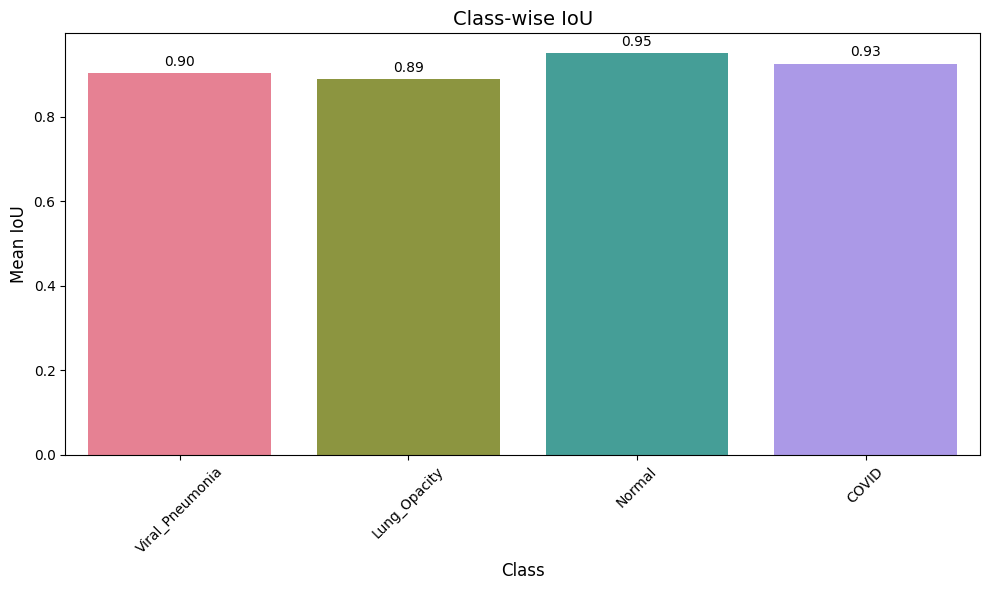

In [62]:
classes = list(iou_summary.keys())
mean_ious = list(iou_summary.values())

# Create color palette
colors = sns.color_palette('husl', len(classes))  # Use different colors for each bar

# Plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=classes, y=mean_ious, palette=colors)

# Add exact numbers on top of the bars
for bar, iou in zip(bars.patches, mean_ious):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the text
        bar.get_height() + 0.01,           # Y-coordinate of the text, slightly above the bar
        f"{iou:.2f}",                      # Text (rounded IoU value)
        ha="center",                       # Horizontal alignment
        va="bottom",                       # Vertical alignment
        fontsize=10                        # Font size
    )

# Add titles and labels
plt.title("Class-wise IoU", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Mean IoU", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Conclusion for Segmentation Task:** The fine-tuned SAM-2 model achieved an impressive overall accuracy (IoU) of 91.07%, demonstrating its strong capability for segmentation tasks. Among the classes, Normal cases exhibited the highest Mean IoU (95%), indicating exceptional segmentation accuracy. COVID and Viral Pneumonia classes also performed well, with Mean IoUs of 93% and 90%, respectively, while Lung Opacity showed slightly lower but still robust performance with a Mean IoU of 89%. These results highlight the model's reliability and effectiveness across diverse segmentation categories.

## 3. Classification with Extracted Features

In this section, features extracted from the fine-tuned SAM-2 model are used to classify images into predefined categories. Various machine learning classifiers such as K-Nearest Neighbors (KNN), Random Forest, Logistic Regression, and Decision Tree are trained and evaluated. The classification process includes hyperparameter tuning, model evaluation using metrics like accuracy and F1-score, and visualization of results through confusion matrices and feature-based plots.

### 3.1. Prepare Data for Classification

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import random

# Load the saved model
checkpoint_path = "fine_tuned_sam2.torch"  # Path to saved model
predictor = SAM2ImagePredictor(load_model(checkpoint_path))

# Collect results
images, gt_masks, pred_masks, gt_class_names, pred_class_names, iou_per_class = collect_results(predictor, test_data, num_samples=200)

# Step 1: Prepare Data for Classifiers
features = []
labels = []

for pred_mask, gt_mask, class_name in zip(pred_masks, gt_masks, gt_class_names):
    # Flatten the predicted mask and ground truth mask
    features.append(pred_mask.flatten())
    labels.append(class_name)  # Use the class name as the label

X = np.array(features)
y = np.array(labels)

### 3.2. Function to calculate and plot confusion matrix for classifiers:

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_metrics_and_plot_cm(y_true, y_pred, class_labels, classifier_name):
    """
    Compute confusion matrix, sensitivity, specificity, and plot the confusion matrix.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - class_labels: array-like, unique class labels
    - classifier_name: str, name of the classifier for display purposes

    Returns:
    - metrics_summary: DataFrame with TP, FP, FN, TN, Sensitivity, and Specificity for each class
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a summary DataFrame
    headers = ['TP', 'FP', 'FN', 'TN', 'Sensitivity', 'Specificity']
    metrics_summary = pd.DataFrame(index=class_labels, columns=headers)

    # Calculate metrics for each class
    for i, class_label in enumerate(class_labels):
        tp = cm[i, i]  # True Positives
        fp = cm[:, i].sum() - tp  # False Positives
        fn = cm[i, :].sum() - tp  # False Negatives
        tn = cm.sum() - (tp + fp + fn)  # True Negatives
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity = TP / (TP + FN)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity = TN / (TN + FP)

        metrics_summary.loc[class_label] = [tp, fp, fn, tn, sensitivity, specificity]

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return metrics_summary


### 3.3. Function to visualize true and predicted masks for a random selection of images:

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random

def visualize_masks(images, gt_masks, pred_masks, y_pred, gt_class_names, class_colors, num_samples=5):
    """
    Visualize true and predicted masks for a random selection of images.

    Parameters:
    - images: List of original images.
    - gt_masks: List of ground truth masks.
    - pred_masks: List of predicted masks.
    - y_pred: List of predicted class names.
    - gt_class_names: List of true class names.
    - class_colors: Dictionary mapping class names to RGB colors.
    - num_samples: Number of random samples to visualize.
    """
    # Ensure all lists are of the same length
    min_length = min(len(images), len(gt_masks), len(pred_masks), len(y_pred), len(gt_class_names))

    # Randomly select indices for the samples to visualize
    sample_indices = random.sample(range(min_length), min(num_samples, min_length))

    for idx in sample_indices:
        img = images[idx]
        true_mask = gt_masks[idx].astype(np.uint8)  # Ensure mask is in the correct format
        pred_mask = pred_masks[idx].astype(np.uint8)  # Ensure mask is in the correct format
        pred_class = y_pred[idx]
        true_class_name = gt_class_names[idx]

        # Create overlay for true mask
        true_overlay = np.zeros_like(img)
        for class_name, color in class_colors.items():
            if class_name in true_class_name:  # Check if the class is in the mask path
                true_overlay[true_mask > 0] = color  # Apply color where the true mask is present

        # Create overlay for predicted mask
        pred_overlay = np.zeros_like(img)
        if pred_class in class_colors:  # Check if the predicted class is valid
            pred_overlay[pred_mask > 0] = class_colors[pred_class]  # Apply color for predicted class

        # Combine original image with overlays
        img_with_true_mask = cv2.addWeighted(img, 1, true_overlay, 0.5, 0)  # Original image with true mask overlay
        img_with_pred_mask = cv2.addWeighted(img, 1, pred_overlay, 0.5, 0)  # Original image with predicted mask overlay

        # Display true mask overlay
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_with_true_mask, cv2.COLOR_BGR2RGB))
        plt.title(f'True Mask Overlay: {true_class_name}')
        plt.axis('off')

        # Display predicted mask overlay
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_with_pred_mask, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted Mask Overlay: {pred_class}')
        plt.axis('off')

        plt.show()

# Example usage:
# Define colors for each class for visualization
class_colors = {
    "COVID": (255, 0, 0),         # Red
    "Lung_Opacity": (0, 255, 0),  # Green
    "Viral_Pneumonia": (0, 0, 255),# Blue
    "Normal": (255, 255, 0)       # Yellow
}

# Call the function to visualize masks
# visualize_masks(images, gt_masks, pred_masks, y_pred_best_knn, gt_class_names, class_colors)

## Classifiers:

### 1. KNN Classifier
- This step tunes the K-Nearest Neighbors (KNN) classifier using GridSearchCV to find the optimal parameters (number of neighbors, distance metric).

In [66]:
from sklearn.model_selection import GridSearchCV

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Use the best estimator to predict
best_knn = grid_search.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)

# Print classification report for the best KNN
print("Classification Report for Best KNN:\n", classification_report(y_test, y_pred_best_knn))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Score: 0.80625
Classification Report for Best KNN:
                  precision    recall  f1-score   support

          COVID       1.00      0.50      0.67        10
   Lung_Opacity       0.50      0.70      0.58        10
         Normal       0.79      0.85      0.81        13
Viral_Pneumonia       1.00      1.00      1.00         7

       accuracy                           0.75        40
      macro avg       0.82      0.76      0.77        40
   weighted avg       0.81      0.75      0.75        40



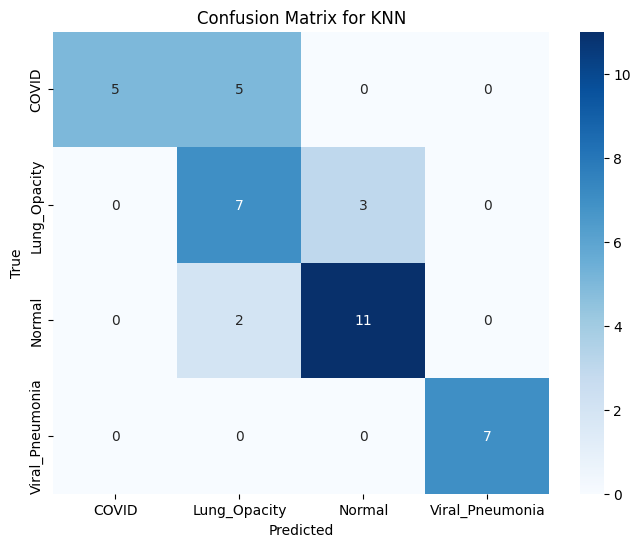

TP FP FN  TN Sensitivity Specificity
COVID             5  0  5  30         0.5         1.0
Lung_Opacity      7  7  3  23         0.7    0.766667
Normal           11  3  2  24    0.846154    0.888889
Viral_Pneumonia   7  0  0  33         1.0         1.0

In [67]:
class_labels = np.unique(y)
compute_metrics_and_plot_cm(y_test, y_pred_best_knn, class_labels, "KNN")

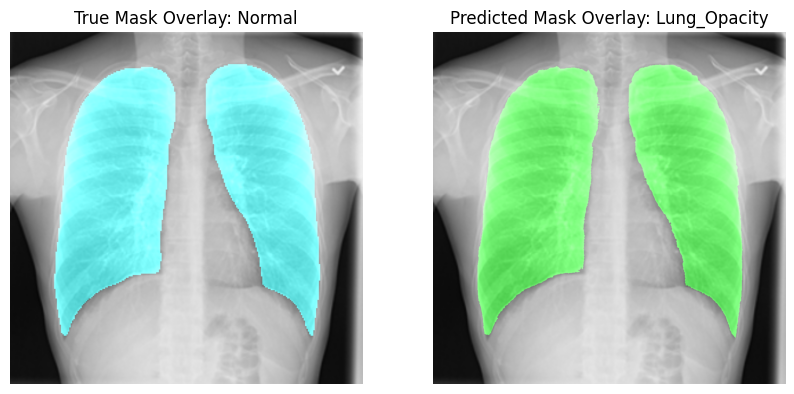

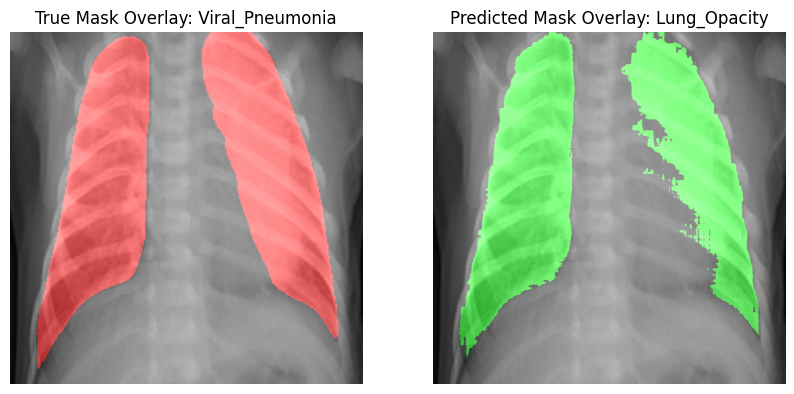

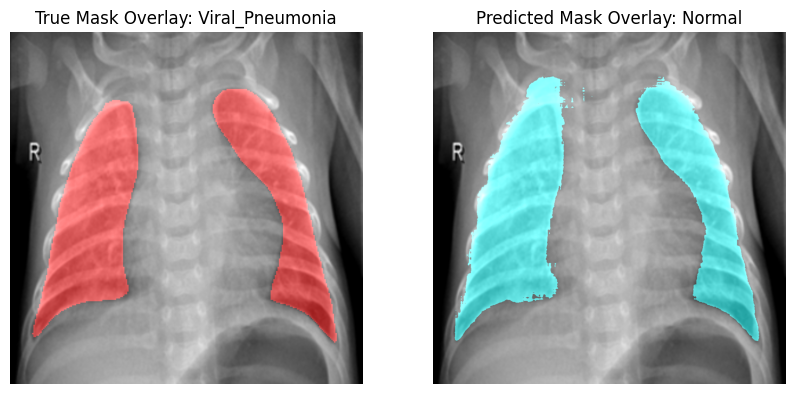

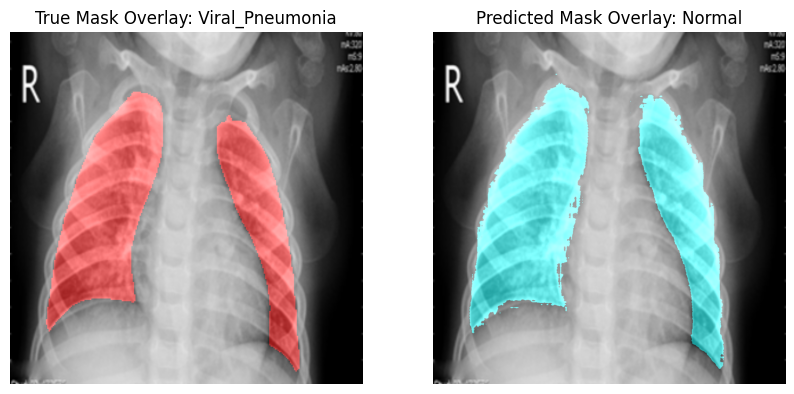

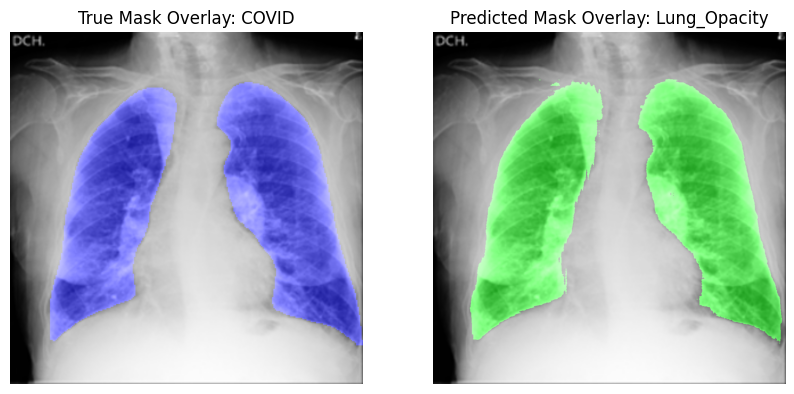

In [84]:
visualize_masks(images, gt_masks, pred_masks, y_pred_best_knn, gt_class_names, class_colors)

### 2. Random Forest Classifier
- This step uses a Random Forest classifier with 100 decision trees to classify the dataset. After training on the training set, predictions are made on the test set, and the classification performance is summarized in a detailed report.

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Print classification report for Random Forest
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
                  precision    recall  f1-score   support

          COVID       1.00      0.50      0.67        10
   Lung_Opacity       0.57      0.80      0.67        10
         Normal       0.92      0.92      0.92        13
Viral_Pneumonia       0.88      1.00      0.93         7

       accuracy                           0.80        40
      macro avg       0.84      0.81      0.80        40
   weighted avg       0.85      0.80      0.80        40



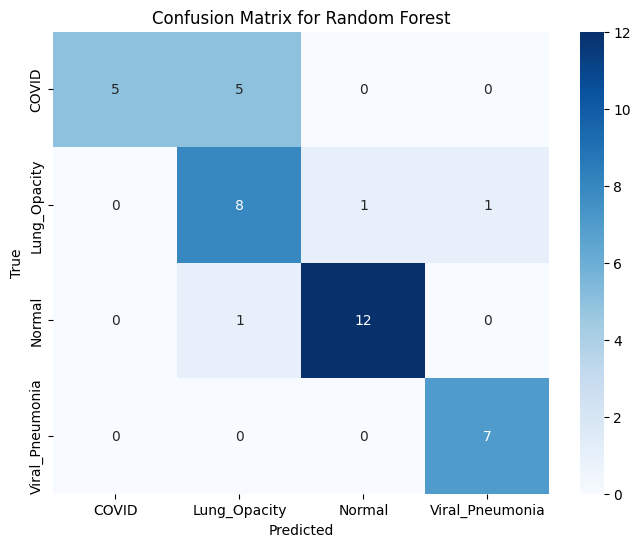

TP FP FN  TN Sensitivity Specificity
COVID             5  0  5  30         0.5         1.0
Lung_Opacity      8  6  2  24         0.8         0.8
Normal           12  1  1  26    0.923077    0.962963
Viral_Pneumonia   7  1  0  32         1.0    0.969697

In [70]:
class_labels = np.unique(y)
compute_metrics_and_plot_cm(y_test, y_pred_rf, class_labels, "Random Forest")

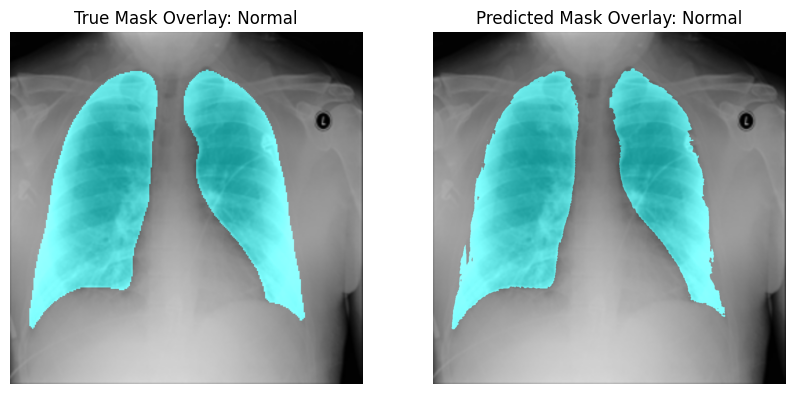

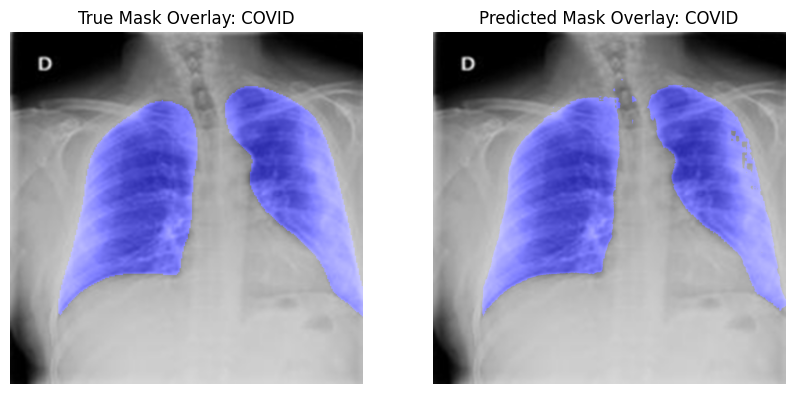

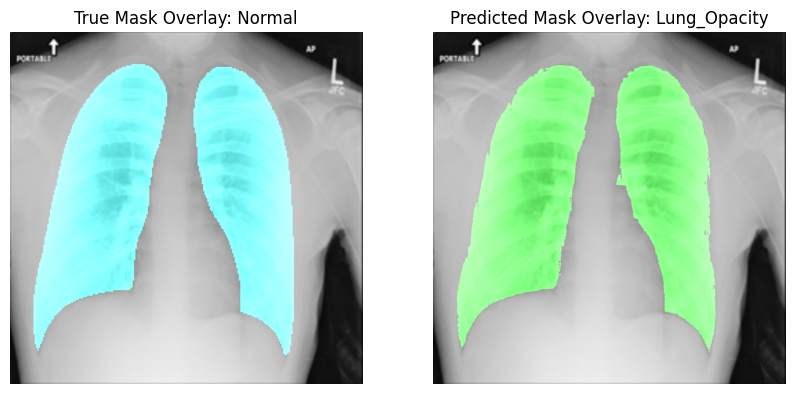

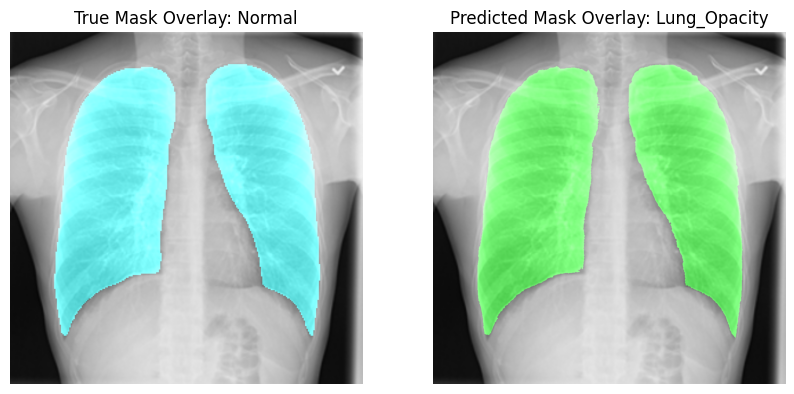

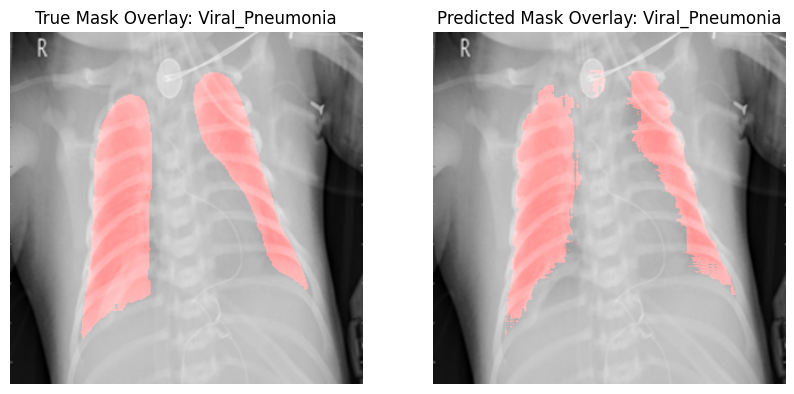

In [89]:
visualize_masks(images, gt_masks, pred_masks, y_pred_rf, gt_class_names, class_colors)

### 3. Decision Tree Classifier
This step employs a Decision Tree classifier with optimized hyperparameters (max_depth, min_samples_split, and min_samples_leaf) to classify the dataset.

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Classify using Decision Tree with optimizations
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Print classification report for Decision Tree
print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))

Classification Report for Decision Tree:
                  precision    recall  f1-score   support

          COVID       0.60      0.30      0.40        10
   Lung_Opacity       0.67      0.80      0.73        10
         Normal       0.67      0.77      0.71        13
Viral_Pneumonia       0.62      0.71      0.67         7

       accuracy                           0.65        40
      macro avg       0.64      0.65      0.63        40
   weighted avg       0.64      0.65      0.63        40



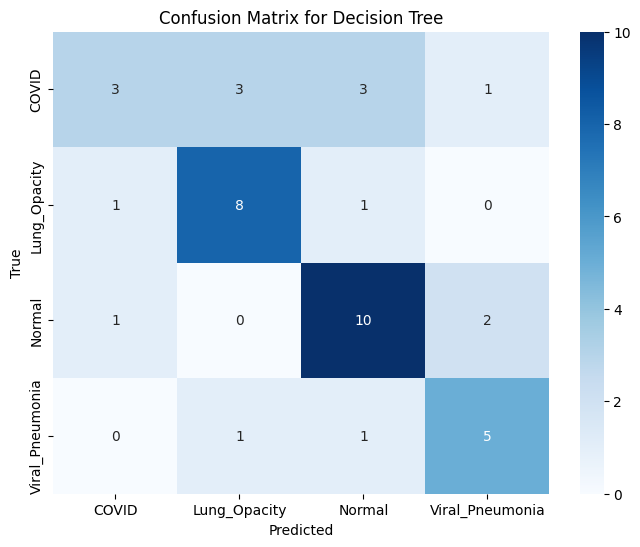

TP FP FN  TN Sensitivity Specificity
COVID             3  2  7  28         0.3    0.933333
Lung_Opacity      8  4  2  26         0.8    0.866667
Normal           10  5  3  22    0.769231    0.814815
Viral_Pneumonia   5  3  2  30    0.714286    0.909091

In [73]:
class_labels = np.unique(y)
compute_metrics_and_plot_cm(y_test, y_pred_dt, class_labels, "Decision Tree")

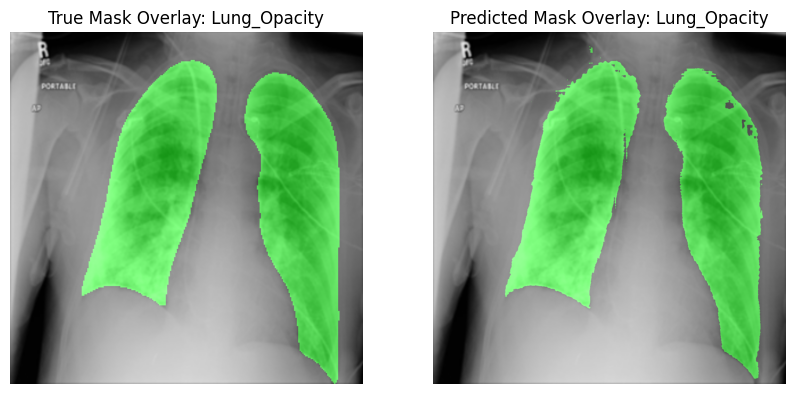

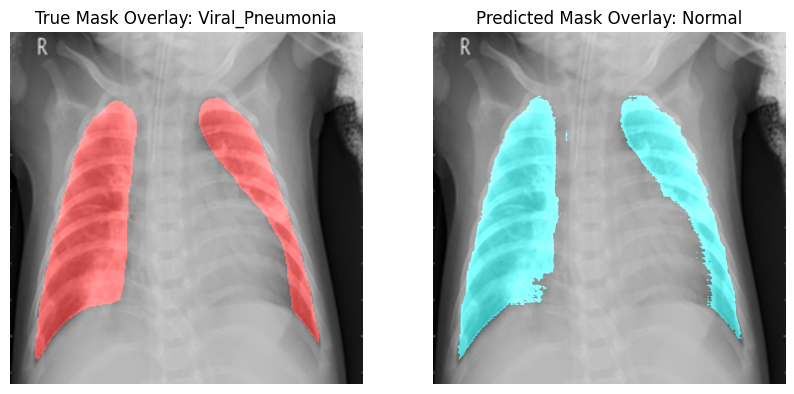

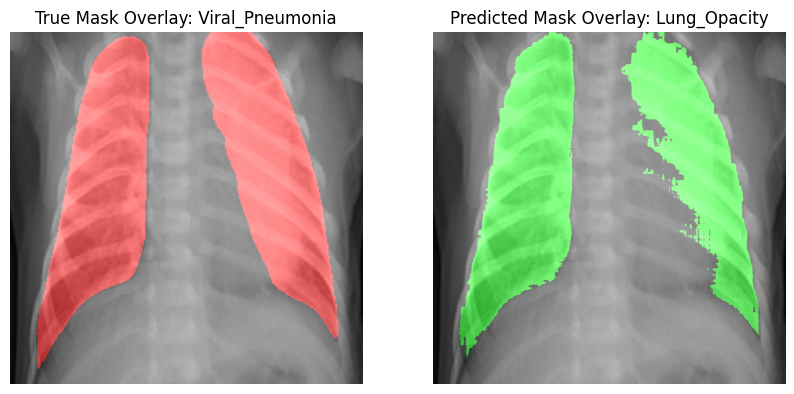

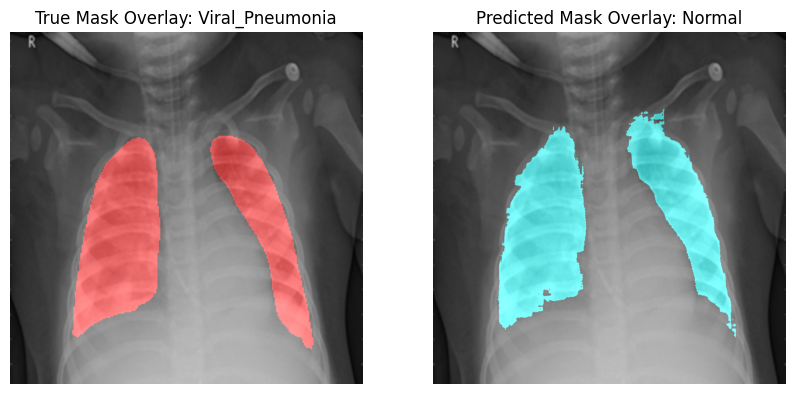

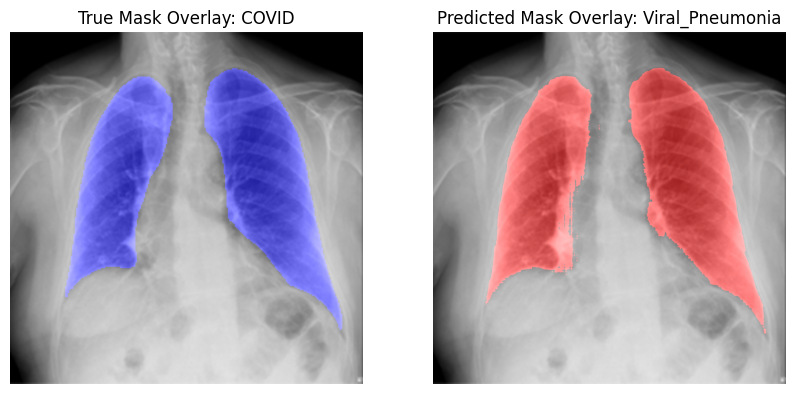

In [90]:
visualize_masks(images, gt_masks, pred_masks, y_pred_dt, gt_class_names, class_colors)

### 4. Logistic Regression
This step uses Logistic Regression to classify the dataset. The model is trained on the training set with a maximum of 1000 iterations and tested on the test set.

In [75]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Classify using Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Print classification report for Logistic Regression
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Classification Report for Logistic Regression:
                  precision    recall  f1-score   support

          COVID       0.83      0.50      0.62        10
   Lung_Opacity       0.67      0.80      0.73        10
         Normal       0.80      0.92      0.86        13
Viral_Pneumonia       1.00      1.00      1.00         7

       accuracy                           0.80        40
      macro avg       0.82      0.81      0.80        40
   weighted avg       0.81      0.80      0.79        40



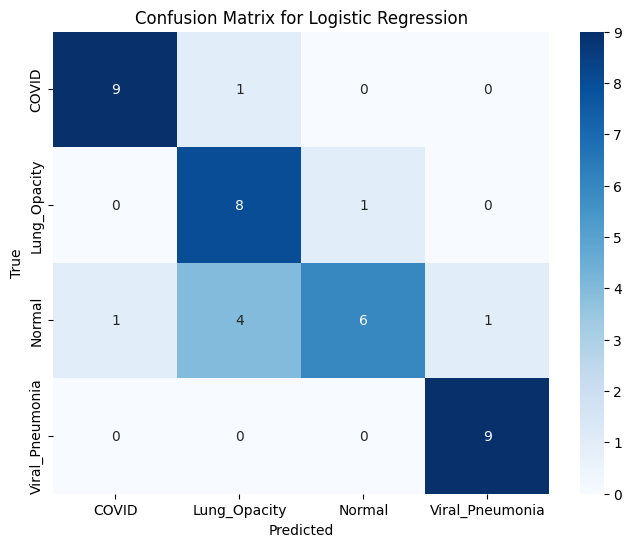

TP FP FN  TN Sensitivity Specificity
COVID            9  1  1  29         0.9    0.966667
Lung_Opacity     8  5  1  26    0.888889     0.83871
Normal           6  1  6  27         0.5    0.964286
Viral_Pneumonia  9  1  0  30         1.0    0.967742

In [58]:
class_labels = np.unique(y)
compute_metrics_and_plot_cm(y_test, y_pred_lr, class_labels, "Logistic Regression")

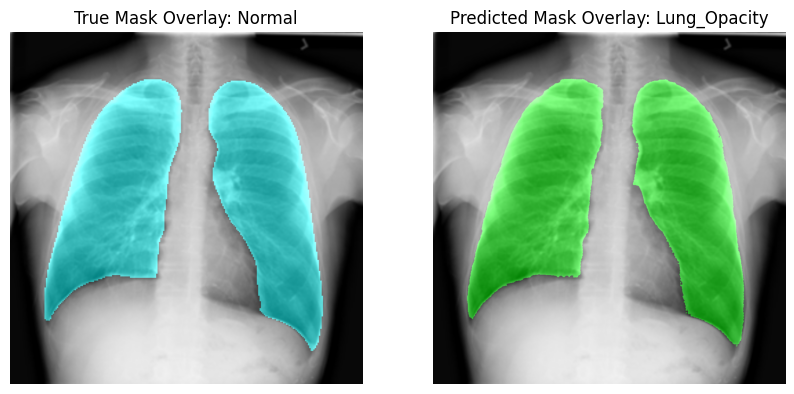

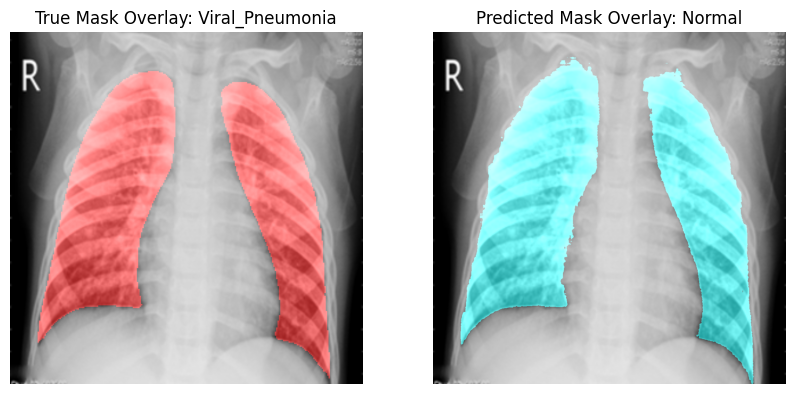

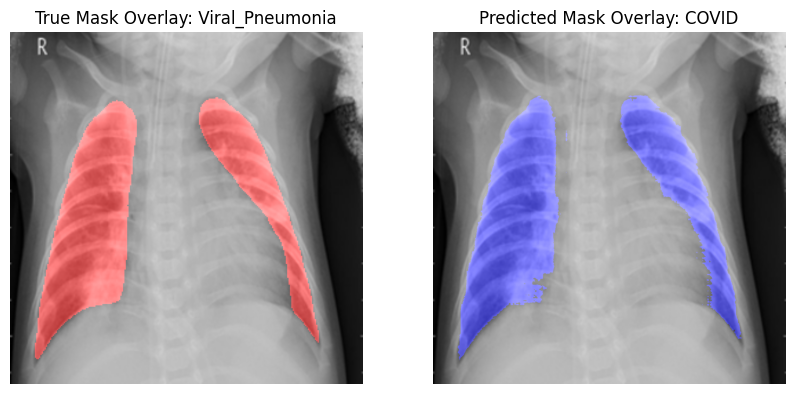

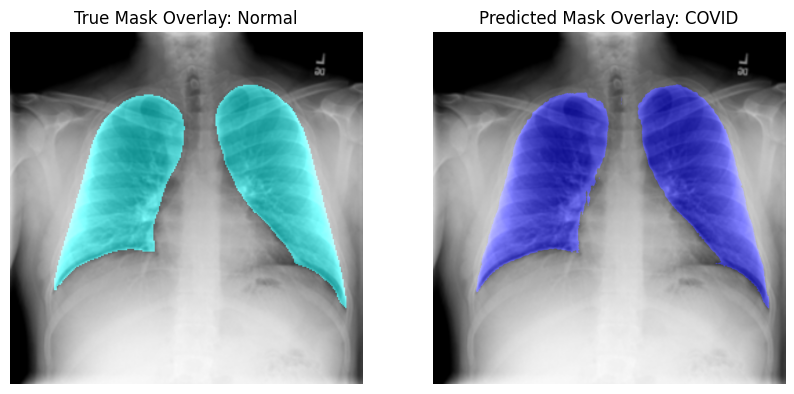

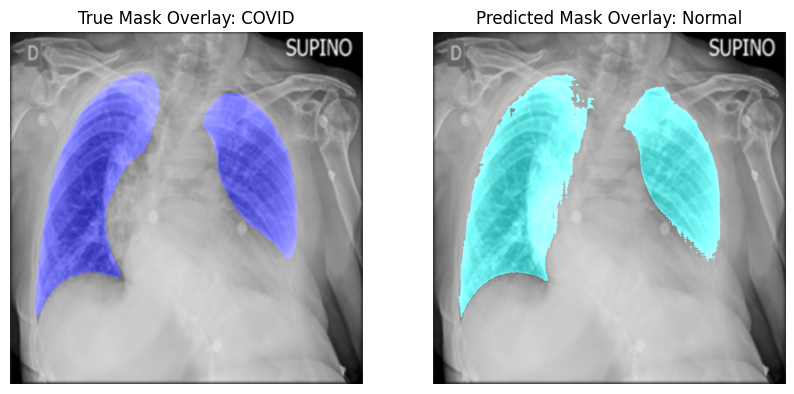

In [94]:
visualize_masks(images, gt_masks, pred_masks, y_pred_lr, gt_class_names, class_colors)

## Classification Results:

In [95]:
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Calculate metrics for KNN
accuracy_knn = accuracy_score(y_test, y_pred_best_knn)
f1_knn = f1_score(y_test, y_pred_best_knn, average='weighted')  # Use 'macro' or 'micro' as needed

# Step 2: Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Step 3: Calculate metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

# Step 4: Calculate metrics for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Step 5: Create a summary DataFrame
summary_df = pd.DataFrame({
    'Classifier': ['KNN', 'Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy': [accuracy_knn, accuracy_rf, accuracy_lr, accuracy_dt],
    'F1 Score': [f1_knn, f1_rf, f1_lr, f1_dt]
})

# Round F1 Score to 3 decimal places
summary_df['F1 Score'] = summary_df['F1 Score'].round(3)

# Step 6: Display the summary DataFrame
summary_df

Classifier  Accuracy  F1 Score
0                  KNN      0.75     0.752
1        Random Forest      0.80     0.797
2  Logistic Regression      0.80     0.792
3        Decision Tree      0.65     0.631

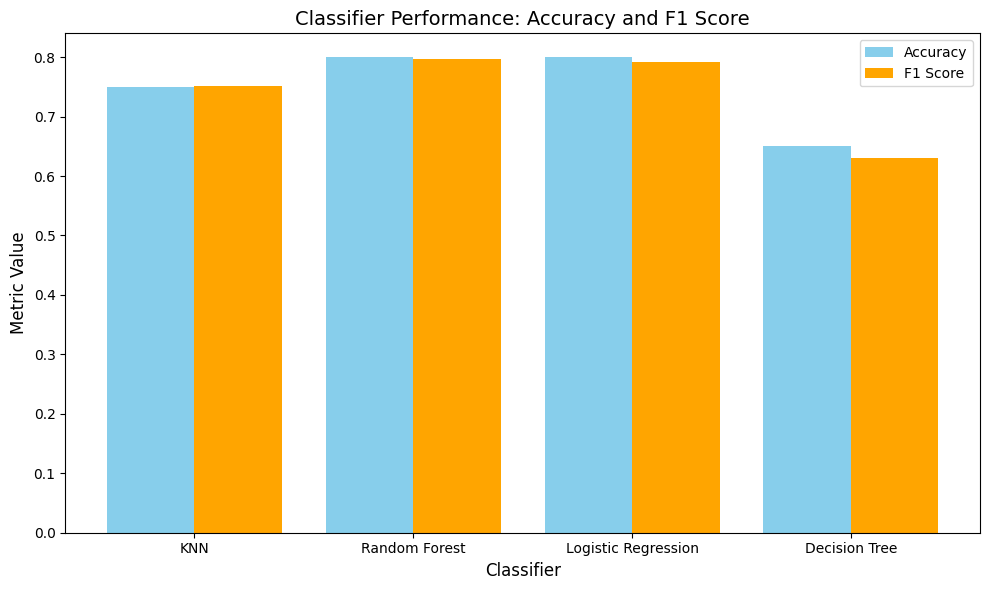

In [96]:
# Create a bar chart for Accuracy and F1 Score
plt.figure(figsize=(10, 6))

# Define positions for the bars
x = range(len(summary_df['Classifier']))
width = 0.4

# Plot Accuracy bars
plt.bar(x, summary_df['Accuracy'], width=width, label='Accuracy', align='center', color='skyblue')

# Plot F1 Score bars shifted slightly to the right
plt.bar([i + width for i in x], summary_df['F1 Score'], width=width, label='F1 Score', align='center', color='orange')

# Add labels and title
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Classifier Performance: Accuracy and F1 Score', fontsize=14)
plt.xticks([i + width / 2 for i in x], summary_df['Classifier'], fontsize=10)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

**Conclusion for Classification Task:** The Random Forest demonstrated the best performance with an accuracy of 80% accuracy, indicating its effectiveness for this dataset. Followed with moderate results Logistic Regression showed 80% accuracy, while KNN achieved slightly lower performance (75% accuracy). The Decision Tree classifier underperformed, achieving only 65% accuracy, suggesting it was less suitable for this task.